# Set up the puzzle

Define a simple sliding tile board with an arrangement of pieces. The "hole" can be moved, depending on where it is on the board.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

hole_value = 0
board_shape = 3
board_size = board_shape * board_shape

starting_pieces = np.arange(board_size, dtype=int).reshape(board_shape, board_shape)
starting_pieces

array([[0, 1, 2],
       [3, 4, 5],
       [6, 7, 8]])

In [2]:
middling_pieces = np.roll(starting_pieces, board_size // 2)
middling_pieces

array([[5, 6, 7],
       [8, 0, 1],
       [2, 3, 4]])

In [3]:
ending_pieces = np.roll(starting_pieces, -1)
ending_pieces

array([[1, 2, 3],
       [4, 5, 6],
       [7, 8, 0]])

In [4]:
def hole_location(pieces):
  return tuple(np.argwhere(pieces == hole_value)[0])

In [5]:
hole_location(middling_pieces)

(1, 1)

In [6]:
def available_hole_moves(pieces):
  """which moves of the hole are possible from this arrangement of pieces
  array of tupes of (axis of array [0, 1], direction of move [-1, 1])"""
  available_moves = []
  origin = hole_location(pieces)
  for i in [0, 1]:
    if (origin[i] - 1) >= 0:
      available_moves.append((i, -1))
    if (origin[i] + 1) < board_shape:
      available_moves.append((i, 1))
  return available_moves

In [7]:
available_hole_moves(ending_pieces)

[(0, -1), (1, -1)]

In [8]:
def hole_destination(origin, move):
  """where the hole will finish after the specified move"""
  destination = list(origin)
  axis = move[0]
  direction = move[1]
  destination[axis] = origin[axis] + direction
  return tuple(destination)

In [9]:
destination = hole_destination(hole_location(middling_pieces), (1, 1))
destination

(1, 2)

In [10]:
middling_pieces[destination]

1

In [11]:
def move_hole(pieces, move):
  """move the piece at the hole destination into the gap in order to move the hole"""
  origin = hole_location(pieces)
  destination = hole_destination(origin, move)
  moving_piece = pieces[destination]
  moved_pieces = np.copy(pieces)
  moved_pieces[origin] = moving_piece
  moved_pieces[destination] = hole_value
  return moved_pieces

In [12]:
move_hole(starting_pieces, (0, 1))

array([[3, 1, 2],
       [0, 4, 5],
       [6, 7, 8]])

In [13]:
move_hole(starting_pieces, (1, 1))

array([[1, 0, 2],
       [3, 4, 5],
       [6, 7, 8]])

In [14]:
move_hole(move_hole(starting_pieces, (1, 1)), (0, 1))

array([[1, 4, 2],
       [3, 0, 5],
       [6, 7, 8]])

# Search for a solution

Find a sequence of moves to reach a target arrangement of the board

In [15]:
def pieces_key(pieces):
  """return immutable comparable representation of board arrangement"""
  return tuple(pieces.flatten())

In [16]:
def same_pieces(p, q):
  """are these arrangements of pieces identical"""
  return pieces_key(p) == pieces_key(q)

In [17]:
middling_pieces_copy = np.copy(middling_pieces)
same_pieces(middling_pieces_copy, middling_pieces)

True

In [18]:
same_pieces(middling_pieces, ending_pieces)

False

In [19]:
def neighbours(visited, path, source, neighbour_test=None):
  """which neighbouring arrangements can be reached in a single move from source
  ignores neighbours previously visited
  applies the optional neighbour_test function if provided
  also accumulates the path from the initial arrangement"""
  if neighbour_test is None:
    neighbour_test = lambda m, n: True
  ns = []
  for move in available_hole_moves(source):
    neighbour = move_hole(source, move)
    if neighbour_test(move, neighbour) and pieces_key(neighbour) not in visited:
      ns.append((path.copy() + [move], neighbour))
  return ns

In [20]:
def solve(source, target, target_as_test=False, neighbour_test=None, limit=1):
  """ search for sequence(s) of moves to reach target, up to limit solutions
  target can be a specified arrangement or another function returning a boolean
  passes neighbour_test function to neighbours search"""
  target_test = target if target_as_test else lambda s: same_pieces(s, target)
  if target_test(source):
    return []
  visited = set([pieces_key(source)])
  stack = neighbours(visited, [], source, neighbour_test)
  solutions = []
  #count = 1
  while len(stack) > 0:
    #count = count + 1
    #if count % 10000 == 0:
    #  print(count, len(visited), len(stack))
    p, s = stack.pop()
    if pieces_key(s) not in visited:
      visited.add(pieces_key(s))
      if target_test(s):
        solutions.append(p)
        if len(solutions) >= limit:
          break
      stack[0:0] = neighbours(visited, p, s, neighbour_test)
  return solutions

In [21]:
solve(starting_pieces, move_hole(starting_pieces, (1, 1)))

[[(1, 1)]]

In [22]:
solve(starting_pieces, move_hole(move_hole(starting_pieces, (1, 1)), (0, 1)))

[[(1, 1), (0, 1)]]

In [23]:
few_moves_pieces = np.array([[3, 2, 5], [4, 0, 1], [6, 7, 8]])
few_moves_pieces

array([[3, 2, 5],
       [4, 0, 1],
       [6, 7, 8]])

In [24]:
solve(few_moves_pieces, starting_pieces)

[[(1, 1), (0, -1), (1, -1), (0, 1), (1, -1), (0, -1)]]

In [25]:
solve(starting_pieces, middling_pieces)

[[(1, 1),
  (1, 1),
  (0, 1),
  (1, -1),
  (0, 1),
  (1, 1),
  (0, -1),
  (1, -1),
  (0, 1),
  (1, -1),
  (0, -1),
  (1, 1),
  (0, -1),
  (1, -1),
  (0, 1),
  (1, 1),
  (0, -1),
  (1, 1),
  (0, 1),
  (1, -1),
  (0, 1),
  (1, -1),
  (0, -1),
  (0, -1),
  (1, 1),
  (0, 1)]]

In [26]:
solve(starting_pieces, ending_pieces)

[[(1, 1),
  (0, 1),
  (1, -1),
  (0, 1),
  (1, 1),
  (1, 1),
  (0, -1),
  (1, -1),
  (1, -1),
  (0, 1),
  (1, 1),
  (0, -1),
  (0, -1),
  (1, 1),
  (0, 1),
  (0, 1),
  (1, -1),
  (1, -1),
  (0, -1),
  (1, 1),
  (1, 1),
  (0, 1)]]

# Model blockers that prevent certain piece arrangements

These tiles now have protruding elements that can interfere to prevent certain arrangements of tiles

In [27]:
# blockers attached to pieces cover cells of basically a 4 x 4 grid with central spines
# x are outer blockers extending beyond the boundaries of the piece
# y are inner blockers within the boundaries of the piece
# this is the next plan - to capture move constraints
# z exists to capture the central spine, which doesn't interfere except when moving
# x x . x x
# x y z y x
# . z z z .
# x y z y x
# x x . x x
blocker_shape = 5
blocker_outer = 2
blocker_inner = blocker_shape - blocker_outer

# 1 blocker grid per piece
blockers_1 = np.zeros((board_size - 1, blocker_shape, blocker_shape), dtype=int)

# game pieces indexed according to puzzle 1
# blockers are zero-indexed but pieces on board are one-indexed as hole is zero
blockers_1[0, 0, 1] = 1
blockers_1[0, 0, 2] = 1
blockers_1[0, 0, 3] = 1
blockers_1[0, 1, 1] = 1
blockers_1[0, 1, 2] = 1
blockers_1[0, 1, 3] = 1
blockers_1[1, 3, 1] = 1
blockers_1[2, 1, 1] = 1
blockers_1[2, 3, 3] = 1
blockers_1[3, 1, 0] = 1
blockers_1[3, 1, 1] = 1
blockers_1[3, 1, 2] = 1
blockers_1[3, 1, 3] = 1
blockers_1[3, 1, 4] = 1
blockers_1[3, 2, 2] = 1
blockers_1[3, 3, 2] = 1
blockers_1[4, 3, 0] = 1
blockers_1[4, 3, 1] = 1
blockers_1[4, 4, 0] = 1
blockers_1[4, 4, 1] = 1
blockers_1[5, 3, 3] = 1
blockers_1[6, 1, 1] = 1
blockers_1[6, 3, 1] = 1
blockers_1[7, 1, 3] = 1

blockers_1[0]

array([[0, 1, 1, 1, 0],
       [0, 1, 1, 1, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0]])

In [28]:
def piece_location(pieces, index):
  return tuple(np.argwhere(pieces == index)[0])

In [29]:
def superpose_blockers(pieces, blockers):
  """count the piece blockers present in each board grid cell"""
  grid_shape = board_shape * blocker_inner + blocker_outer
  grid = np.zeros((grid_shape, grid_shape), dtype=int)
  for i in range(board_size - 1):
    offset = tuple(np.array(piece_location(pieces, i + 1)) * blocker_inner)
    piece_slice = np.s_[offset[0]:offset[0] + blocker_shape, offset[1]:offset[1] + blocker_shape]
    grid[piece_slice] = grid[piece_slice] + blockers[i, ...]
  return grid

In [30]:
def blocker_interference(pieces, blockers):
  """test whether blockers interfere"""
  grid = superpose_blockers(pieces, blockers)
  return np.max(grid) > 1

In [31]:
blocker_1_pieces_start = np.array([[1, 2, 3], [4, 5, 6], [7, 0, 8]])
blocker_1_pieces_invalid = np.array([[1, 2, 3], [0, 5, 6], [7, 4, 8]])

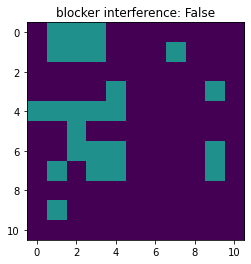

In [32]:
plt.imshow(superpose_blockers(blocker_1_pieces_start, blockers_1), vmax=2)
plt.title(f'blocker interference: {blocker_interference(blocker_1_pieces_start, blockers_1)}')
plt.show()

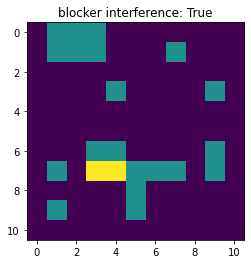

In [33]:
plt.imshow(superpose_blockers(blocker_1_pieces_invalid, blockers_1), vmax=2)
plt.title(f'blocker interference: {blocker_interference(blocker_1_pieces_invalid, blockers_1)}')
plt.show()

# Solve an easy puzzle

Solve an easy version of the puzzle with blockers

In [34]:
def piece_at_location(pieces, index, location):
  return piece_location(pieces, index) == location

In [35]:
piece_at_location(blocker_1_pieces_start, 4, (1, 0)), piece_at_location(blocker_1_pieces_start, 4, (1, 1))

(True, False)

In [36]:
solve(blocker_1_pieces_start,
      lambda ps: piece_at_location(ps, 4, (2, 1)),
      True,
      lambda m, ps: not blocker_interference(ps, blockers_1))

[[(0, -1), (1, -1), (0, 1), (1, 1), (0, -1)]]

# Model blockers that prevent certain piece arrangements and moves

Now we also consider piece blockers interfering during the movement of tiles between arrangements

In [37]:
blockers_60 = np.zeros((board_size - 1, blocker_shape, blocker_shape), dtype=int)
blockers_60[0, 1, 0] = 1
blockers_60[0, 1, 1] = 1
blockers_60[0, 1, 2] = 1
blockers_60[0, 1, 3] = 1
blockers_60[0, 1, 4] = 1
blockers_60[0, 2, 2] = 1
blockers_60[0, 3, 2] = 1
blockers_60[1, 3, 1] = 1
blockers_60[1, 3, 3] = 1
blockers_60[2, 1, 3] = 1
blockers_60[3, 1, 1] = 1
blockers_60[4, 1, 1] = 1
blockers_60[5, 1, 0] = 1
blockers_60[5, 1, 1] = 1
blockers_60[5, 2, 0] = 1
blockers_60[5, 2, 1] = 1
blockers_60[5, 3, 0] = 1
blockers_60[5, 3, 1] = 1
blockers_60[6, 0, 3] = 1
blockers_60[6, 0, 4] = 1
blockers_60[6, 1, 3] = 1
blockers_60[6, 1, 4] = 1
blockers_60[7, 1, 3] = 1
blockers_60[7, 3, 1] = 1

blockers_60[0]

array([[0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1],
       [0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0]])

In [38]:
blocker_60_pieces_start = np.array([[1, 2, 3], [4, 0, 5], [6, 7, 8]])

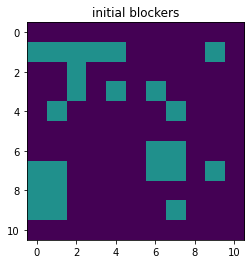

In [39]:
plt.imshow(superpose_blockers(blocker_60_pieces_start, blockers_60), vmax=2)
plt.title('initial blockers')
plt.show()

In [40]:
def reverse_move(move):
  return (move[0], -move[1])

In [41]:
def hole_origin(move, destination):
  return hole_destination(destination, reverse_move(move))

In [42]:
def moved_piece(move, pieces_end):
  hole_dest = hole_location(pieces_end)
  hole_orig = hole_origin(move, hole_dest)
  return pieces_end[hole_orig]

In [43]:
moved_horz_blocker_60_pieces = move_hole(blocker_60_pieces_start, (1, 1))
moved_horz_blocker_60_pieces

array([[1, 2, 3],
       [4, 5, 0],
       [6, 7, 8]])

In [44]:
moved_piece((1, 1), moved_horz_blocker_60_pieces) == 5

True

In [45]:
def interpolate_superpose_blockers(move, pieces_end, blockers):
  """count the piece blockers present in each board grid cell as the tile moves"""
  i_moved = moved_piece(move, pieces_end)
  grid_shape = board_shape * blocker_inner + blocker_outer
  grids = []
  for s in range(blocker_inner + 1):
    grid = np.zeros((grid_shape, grid_shape), dtype=int)
    for i in range(board_size - 1):
      move_offset = np.array([0, 0])
      if i + 1 == i_moved:
        move_offset[move[0]] = s * move[1]
      offset = tuple((np.array(piece_location(pieces_end, i + 1)) * blocker_inner) + move_offset)
      piece_slice = np.s_[offset[0]:offset[0] + blocker_shape, offset[1]:offset[1] + blocker_shape]
      grid[piece_slice] = grid[piece_slice] + blockers[i, ...]
    grids.insert(0, grid)
  return grids

In [46]:
def interpolate_blocker_interference(move, pieces_end, blockers):
  """test whether blockers interfere"""
  grids = interpolate_superpose_blockers(move, pieces_end, blockers)
  return max([np.max(g) for g in grids]) > 1  

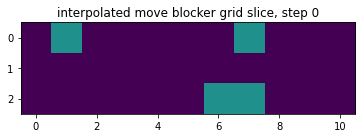

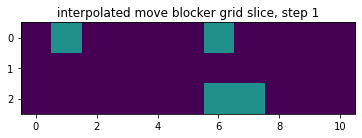

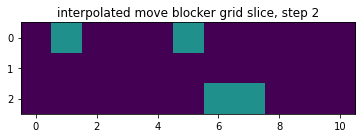

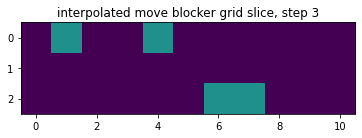

blocker interference: False


In [47]:
grids = interpolate_superpose_blockers((1, 1), moved_horz_blocker_60_pieces, blockers_60)

for s, g in enumerate(grids):
  plt.imshow(g[4:7,:], vmax=2)
  plt.title(f'interpolated move blocker grid slice, step {s}')
  plt.show()

print(f'blocker interference: {interpolate_blocker_interference((1, 1), moved_horz_blocker_60_pieces, blockers_60)}')

In [48]:
moved_vert_blocker_60_pieces = move_hole(blocker_60_pieces_start, (0, 1))
moved_vert_blocker_60_pieces

array([[1, 2, 3],
       [4, 7, 5],
       [6, 0, 8]])

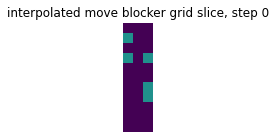

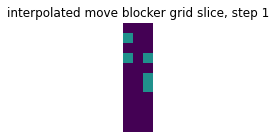

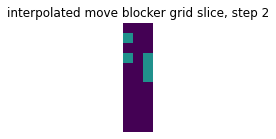

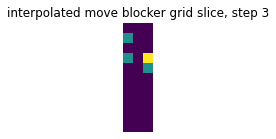

blocker interference: True


In [49]:
grids = interpolate_superpose_blockers((0, 1), moved_vert_blocker_60_pieces, blockers_60)

for s, g in enumerate(grids):
  plt.figure(figsize=(6, 2))
  plt.imshow(g[:,4:7], vmax=2)
  plt.axis('off')
  plt.title(f'interpolated move blocker grid slice, step {s}')
  plt.show()

print(f'blocker interference: {interpolate_blocker_interference((0, 1), moved_vert_blocker_60_pieces, blockers_60)}')

In [50]:
def exit_interference(ps, blockers):
  """test whether the exit path has blocker interference"""
  grid = superpose_blockers(ps, blockers)
  return np.sum(grid[-2:, blocker_inner:blocker_inner + 2]) + \
         np.sum(grid[-2:, 2 * blocker_inner: 2 * blocker_inner + 2]) > 0

In [51]:
blocked_exit = np.array([[4, 5, 7], [6, 0, 3], [2, 1, 8]])
exit_interference(blocked_exit, blockers_60)

True

In [52]:
clear_exit = np.array([[4, 5, 7], [6, 2, 8], [0, 1, 3]])
exit_interference(clear_exit, blockers_60)

False

#Solve a hard puzzle

Solve a hard version of the puzzle with blockers, that requires testing whether moves, as well as arrangements, (and including the last exit move I don't otherwise model) are free of interference as well as arrangements

In [53]:
solutions = solve(blocker_60_pieces_start,
                  lambda ps: piece_at_location(ps, 1, (2, 1)) and not exit_interference(ps, blockers_60),
                  True,
                  lambda m, ps: not interpolate_blocker_interference(m, ps, blockers_60),
                  10)

In [54]:
[len(s) for s in solutions]

[108, 109, 109, 109, 110, 110, 110, 110, 110, 111]